timestamp – дата и время (точность до часа)
cnt – количество аренд велосипедов за этот час
t1 – температура, в С
t2 – температура "ощущается как", в С 
hum – влажность (%)
wind_speed – скорость ветра, км/ч
weather_code – погодные условия:
    1 – ясно (SKC)
    2 – преимущественно ясно / встречаются отдельные облака (SCT)
    3 – облачно / значительные облака (BKN)
    4 – пасмурно (OVC)
    7 – небольшой дождь Rain/ light Rain shower/ Light rain 
    10 – дождь с грозой
    26 – снегопад 
    94 – ледяной туман (да, такое бывает!)
isholiday – является ли день праздником (1 – праздник, 0 – нет)
isweekend –  является ли день выходным (1 – выходной, 0 – нет)
season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px 
import os
%matplotlib inline
import scipy.stats as sps
sns.set(font_scale = 2, style='whitegrid',rc={'figure.figsize':(20,7)})

In [50]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-varenichenko-22/My_practice/Modul_6_Statistics/london.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [51]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [35]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

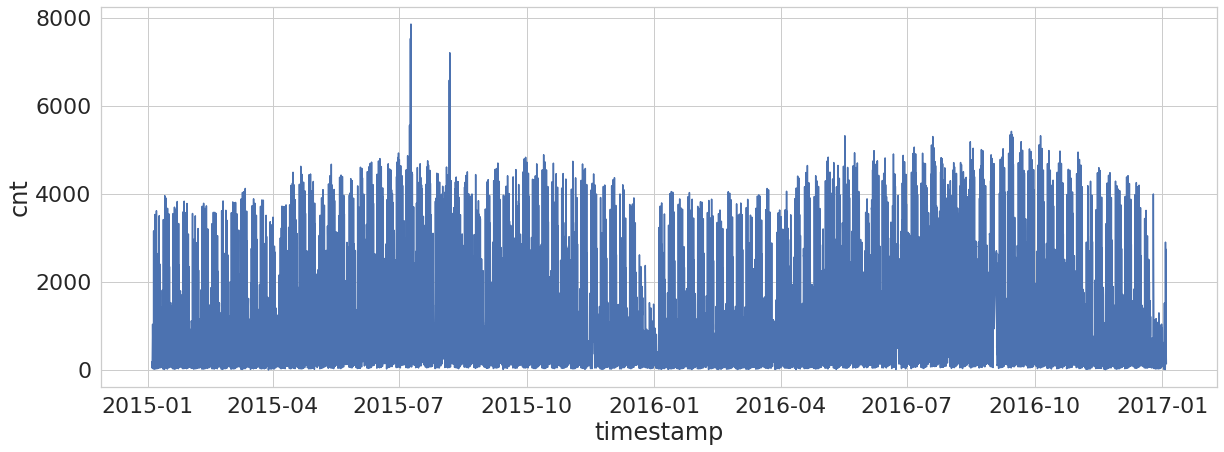

In [22]:
# Посмотрим на число поездок по датам и времени:
ax = sns.lineplot(x = 'timestamp', y = 'cnt', data = df)   

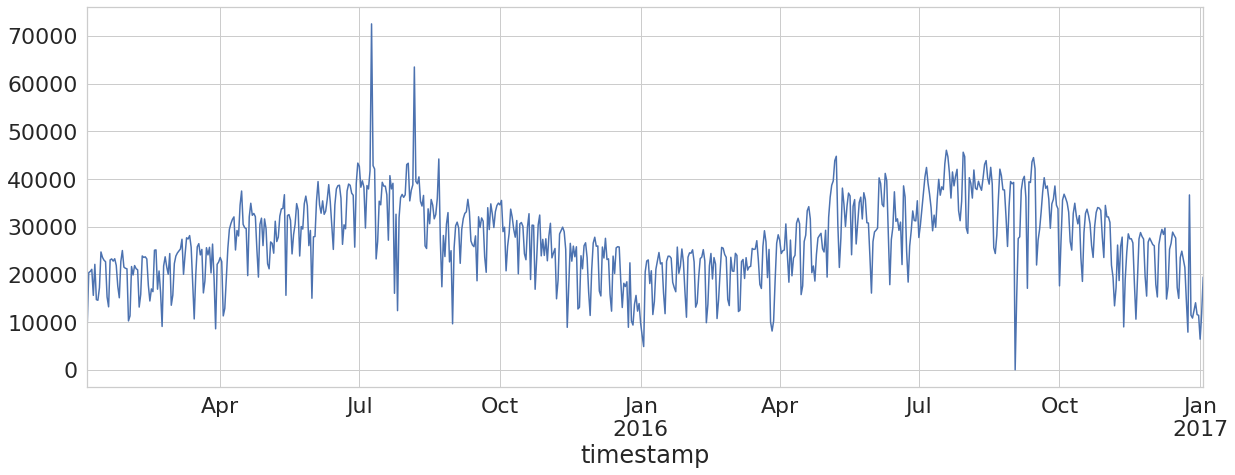

In [52]:
# Агрегируем число поездок по дням и визуализируем результат

df.sort_values('timestamp').set_index('timestamp').resample(rule='D').cnt.sum().plot()


In [55]:
# Предыдущий шаг преобразуем в датафрейм
df_2 = df.sort_values('timestamp') \
         .set_index('timestamp') \
         .resample(rule='D') \
         .agg({'cnt':'sum'}) \
         .rename(columns={'cnt':'cnt_sum'}) \
         .reset_index()
df_2

In [46]:
df_1['2015-07-09']

50705.0

In [66]:
# сначала посчитаем скользящее среднее, чтобы сгладить ряд
df_2['rolling_mean'] = df_2.cnt_sum \
                         .rolling(3) \
                         .mean()
df_2

,timestamp,cnt_sum,rolling_mean
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,16739.666667
3,2015-01-07,21064,20683.000000
4,2015-01-08,15601,19092.666667
...,...,...,...
726,2016-12-30,11566,12682.000000
727,2016-12-31,11424,12347.333333
728,2017-01-01,6421,9803.666667
729,2017-01-02,11823,9889.333333


In [67]:
# Посчитаем разницу между наблюдаемыми(cnt_sum) и подсчитанными значениями(rolling_mean).
df_2['difference'] = df_2.rolling_mean - df_2.cnt_sum


In [69]:
# Далее – посмотрим на стандартное отклонение
std = np.std(df_2['difference'])
round(std, 2)

4558.59

In [71]:
# Oпределим границы интервалов при 99% доверительном интервале
df_2['upper_bound'] = df_2.rolling_mean + 2.576*std
df_2['lower_bound'] = df_2.rolling_mean - 2.576*std

In [81]:
# Изучим аномально высокие значения.
# Посмотрим наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала
df_3 = df_2[df_2.apply(lambda x: x['cnt_sum'] > x['upper_bound'], axis = 1)]
df_3

,timestamp,cnt_sum,rolling_mean,difference,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,-21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,-16840.666667,58370.252521,34884.414146
609,2016-09-04,27512,14259.000000,-13253.000000,26001.919188,2516.080812
721,2016-12-25,36653,19650.666667,-17002.333333,31393.585854,7907.747479


Аномально высокое число аренд 2015-07-09 было из-за забастовки метро

In [85]:
# Посмотрим наблюдения, когда число аренд оказалось ниже ожидаемого
df_4 = df_2[df_2.apply(lambda x: x['cnt_sum'] < x['lower_bound'], axis = 1)]
df_4

,timestamp,cnt_sum,rolling_mean,difference,upper_bound,lower_bound
130,2015-05-14,15609,28709.333333,13100.333333,40452.252521,16966.414146
189,2015-07-12,23240,36036.666667,12796.666667,47779.585854,24293.747479
201,2015-07-24,16034,31013.666667,14979.666667,42756.585854,19270.747479
232,2015-08-24,17400,29529.333333,12129.333333,41272.252521,17786.414146
314,2015-11-14,8898,21037.333333,12139.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,31262.000000,14182.000000,43004.919188,19519.080812
621,2016-09-16,21967,36193.333333,14226.333333,47936.252521,24450.414146
678,2016-11-12,8990,20878.000000,11888.000000,32620.919188,9135.080812


In [93]:
df.query("timestamp == '2016-09-02'")

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season


Анамольно низкое число аренд связано с ошибкой в данных - нет данных для 2016-09-02